In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 1.8)

# Comparing distribution of tokens in train and test

In [2]:
def get_label_file():
    """
    Returns the one-hot encoded label matrix corresponding to the wordpiece-segmented and BIO-encoded SUC3 dataset named entity tags
    """
    data_type = np.uint8
    g = np.memmap('../data/ONE_HOT_LABELS.dat', dtype=data_type, shape=(74165, 100, 33))
    
    return g

In [3]:
def remap(matrix, label_dictionary):
    """
    Utility function to take one-hot encoded labels and return the label with the higest probability
    """
    
    #Switch index to label
    def switcher(x):
        return label_dictionary[x]
    
    #Get the index along the second axis (the one-hot encoding) with the highest value
    predicted_index = pd.DataFrame(np.argmax(matrix, axis=2))
    
    #Use our dictionary to map this index to the class
    label_representation = predicted_index.applymap(switcher)

    return label_representation

In [4]:
# Get all one-hot encoded labels
wordpiece_labels = get_label_file()

# Return them to labels
label_dictionary = np.load("../data/dummy_index_label_dict.npy", allow_pickle=True).tolist()
wordpiece_labels = remap(wordpiece_labels, label_dictionary)

In [5]:
train_labels = wordpiece_labels[66749:]
test_labels = wordpiece_labels[:66749]

In [6]:
#Put all the labels in a single array
df = pd.DataFrame(wordpiece_labels.values.flatten())
df['count'] = 0

#Group them by name and count them
counts = df.groupby(0).count()

counts = counts.T


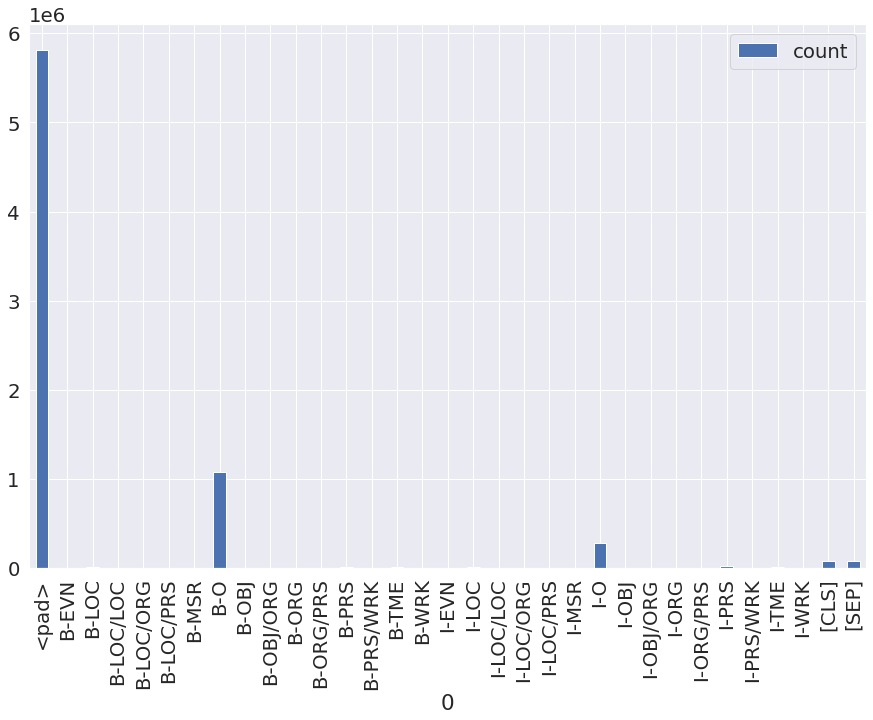

In [7]:
fig, ax = plt.subplots(figsize = (15,10))
counts.T.plot(kind='bar', ax = ax)
plt.show()

In [8]:
#Structural elements and Objects are a bit too dominating
#Skip them
counts = counts.drop(columns = {'<pad>', '[CLS]', '[SEP]', 'I-O', 'B-O'})

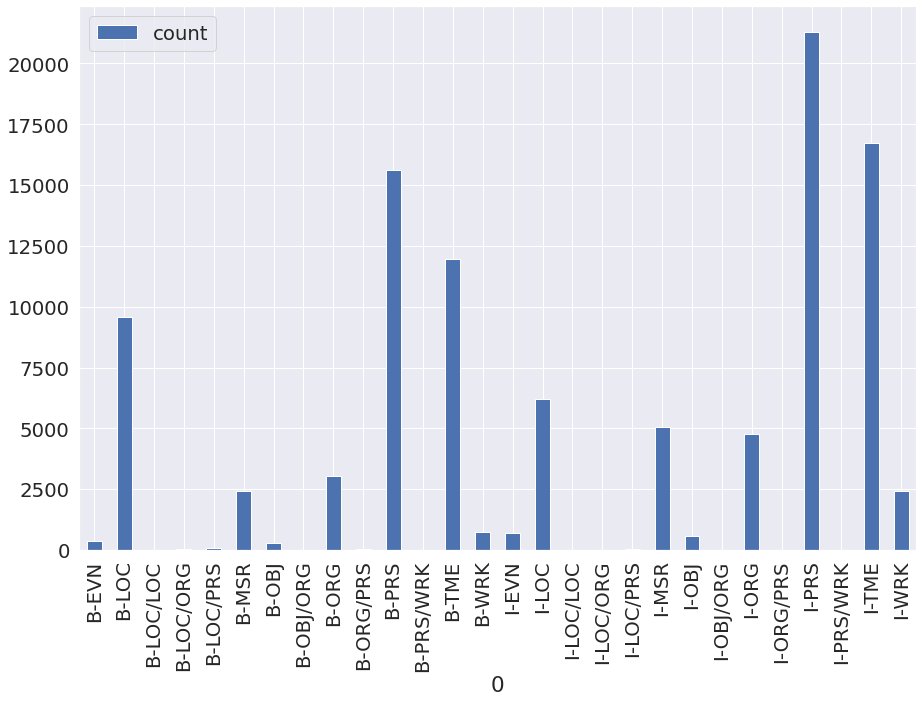

In [9]:
fig, ax = plt.subplots(figsize = (15,10))
counts.T.plot(kind='bar', ax = ax)
plt.show()

In [10]:
# Now to compare train and test
train_labels = wordpiece_labels[:66749]
test_labels = wordpiece_labels[66749:]

#Put all the labels in a single array
train_df = pd.DataFrame(train_labels.values.flatten())
train_df['train_count'] = 0

test_df = pd.DataFrame(test_labels.values.flatten())
test_df['test_count'] = 0

#Group them by name and count them
train_counts = train_df.groupby(0).count()
test_counts = test_df.groupby(0).count()

train_counts = train_counts.T.drop(columns = {'<pad>', '[CLS]', '[SEP]', 'I-O', 'B-O'})
test_counts = test_counts.T.drop(columns = {'<pad>', '[CLS]', '[SEP]', 'I-O', 'B-O'})


In [11]:
train_counts.T['train_count']

0
B-EVN          327
B-LOC         8602
B-LOC/LOC        7
B-LOC/ORG       42
B-LOC/PRS       69
B-MSR         2186
B-OBJ          276
B-OBJ/ORG        1
B-ORG         2735
B-ORG/PRS       23
B-PRS        14044
B-PRS/WRK        6
B-TME        10739
B-WRK          667
I-EVN          628
I-LOC         5665
I-LOC/LOC        8
I-LOC/ORG       15
I-LOC/PRS       44
I-MSR         4548
I-OBJ          541
I-OBJ/ORG        4
I-ORG         4298
I-ORG/PRS       11
I-PRS        19173
I-PRS/WRK       12
I-TME        15013
I-WRK         2195
Name: train_count, dtype: int64

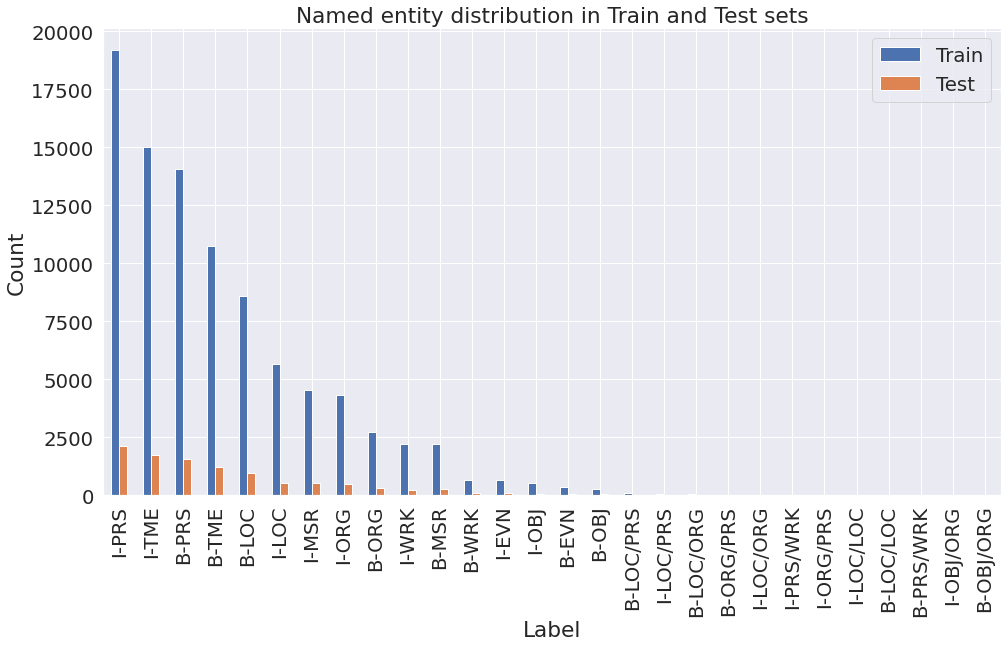

In [12]:
fig, ax = plt.subplots(figsize = (15,10))

merged = pd.DataFrame()
merged['Train'] = train_counts.T['train_count']
merged['Test'] = test_counts.T['test_count']
merged = merged.sort_values(by='Train', ascending = False)


merged.plot(kind = 'bar', ax = ax)
ax.set_xlabel('Label')

ax.set_ylabel('Count')
ax.set_title("Named entity distribution in Train and Test sets")
fig.tight_layout(pad=2)

plt.savefig("../data/assets/trainVStest.png")

plt.show()

# A look at some of the entities

In [13]:
from transformers import AutoModel
from transformers import AutoTokenizer
from embedding_functions import *
import pandas as pd
import torch

# Load the model and tokenizer

model = AutoModel.from_pretrained('KB/albert-base-swedish-cased-alpha')
tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")

#Load the label dictionary
label_dictionary = np.load("../data/dummy_index_label_dict.npy", allow_pickle=True).tolist()
cf_labels = list(label_dictionary.values())

#Update the tokenizer with our labels (which do not exist in the normal vocabulary)
tokenizer.add_tokens(cf_labels)

#Inform the model that we've updated the vocab
model.resize_token_embeddings(len(tokenizer))

Embedding(50030, 128)

In [14]:
# Get the wordpieces
wordpiece_tokens = pd.DataFrame(np.load('../data/sentence_tokens.npy')).applymap(tokenizer.convert_ids_to_tokens)

In [15]:
# And the labels
wordpiece_labels.head(1)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,[CLS],B-O,B-O,B-O,B-O,I-O,B-O,B-O,B-O,B-O,...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>


In [16]:
# Have a long at one exameple
lookat = 10
fix = wordpiece_tokens.iloc[[lookat]].append(wordpiece_labels.iloc[[lookat]])
fix.T.head(25)

,10,10
0,[CLS],[CLS]
1,▁Mark,B-O
2,s,I-O
3,ekt,I-O
4,ionens,I-O
5,▁uppdrag,B-O
6,▁är,B-O
7,▁att,B-O
8,▁se,B-O
9,▁till,B-O


# All examples of a tag with context

In [17]:
print("Possible tags")
print(merged.columns.values)

Possible tags
['Train' 'Test']


In [18]:
wordpiece_labels_longlist = pd.DataFrame(wordpiece_labels.values.flatten())
wordpiece_tokens_longlist = pd.DataFrame(wordpiece_tokens.values.flatten())

In [19]:
def get_tag_examples(nr_examples, tag):
    TAG =  tag
    tag_indices = wordpiece_labels_longlist.index[wordpiece_labels_longlist[0]==TAG].values
    result = wordpiece_tokens_longlist.iloc[tag_indices]

    words = []
    contexts = []
    for index in tag_indices[:100]:
        word = wordpiece_tokens_longlist.iloc[index].values[0]
        context = wordpiece_tokens_longlist[index-5:index+5].values.flatten()
        context = ''.join(context.flatten()).replace('▁', ' ')
        words.append(word)
        contexts.append(context)

    df = pd.DataFrame(columns = {TAG, 'Context'})
    df[TAG] = words
    df['Context'] = contexts
    return(df.head(nr_examples))
    
get_tag_examples(5, 'B-OBJ/ORG')

,B-OBJ/ORG,Context
0,▁Rolls,<pad>[CLS] Vad sägs om Rolls-Royce


# Print tag for report

In [20]:
df = pd.read_pickle('../data/suc3_dataframe')
df['word_type'].unique()

array([nan, 'LOC', 'PRS', 'TME', 'person', 'MSR', 'ORG', 'EVN', 'inst',
       'WRK', 'place', 'OBJ', 'product', 'other', 'work', 'event', 'myth',
       'LOC/ORG', 'LOC/PRS', 'animal', 'ORG/PRS', 'OBJ/ORG', 'LOC/LOC',
       'PRS/WRK'], dtype=object)

In [21]:
#Strange, I don't remember seing animal, product etc.

In [22]:
display(df[df['word_type'] =='product'].head(2))
display(df[df['word_type'] =='person'].head(2))
display(df[df['word_type'] =='myth'].head(2))
display(df[df['word_type'] =='animal'].head(2))

,text_id,text_lix,text_nk,text_ovix,text_swefn,text_index,sentence__geocontext,sentence_id,sentence_index,word_blingbring,...,word_swefn,word_ex,word_name,word_subtype,word_type,word_index,word_tag,word_sentiment,word_sentimentclass,word__overlap
3434,aa02a,35.21,1.46,77.09,|Make_cognitive_connection:144.823|Piracy:135....,153,NaN,686f78e8-6867129a,230,NaN,...,NaN,NaN,\n,NaN,product,3435,w,NaN,NaN,686-5
4405,aa02a,35.21,1.46,77.09,|Make_cognitive_connection:144.823|Piracy:135....,204,NaN,68624390-686eac57,299,NaN,...,NaN,NaN,\n,NaN,product,4406,w,NaN,NaN,NaN


,text_id,text_lix,text_nk,text_ovix,text_swefn,text_index,sentence__geocontext,sentence_id,sentence_index,word_blingbring,...,word_swefn,word_ex,word_name,word_subtype,word_type,word_index,word_tag,word_sentiment,word_sentimentclass,word__overlap
118,aa01c,50.84,1.58,76.88,|Abandonment:95.654|Destroying:87.097|Relation...,4,NaN,e24deac8-e2489f5b,8,NaN,...,NaN,NaN,\n,NaN,person,119,w,NaN,NaN,NaN
932,aa01b,42.69,1.34,69.26,|Commutative_process:145.429|Reparation:91.927...,38,NaN,e24de825-e242f64a,55,NaN,...,NaN,NaN,\n,NaN,person,933,w,NaN,NaN,NaN


,text_id,text_lix,text_nk,text_ovix,text_swefn,text_index,sentence__geocontext,sentence_id,sentence_index,word_blingbring,...,word_swefn,word_ex,word_name,word_subtype,word_type,word_index,word_tag,word_sentiment,word_sentimentclass,word__overlap
35246,ab03b,35.67,0.91,64.09,|Distributed_abundance:154.73|Undergo_change:8...,1653,NaN,0016d384-0014d769,2470,NaN,...,NaN,NaN,\n,NaN,myth,35247,w,NaN,NaN,NaN
56616,ad01a,48.77,1.42,75.43,|Justifying:702.033|Cure_mod:109.703|Arrest:10...,2622,NaN,43b9c7d6-43bb9c93,3943,NaN,...,NaN,NaN,\n,NaN,myth,56617,w,NaN,NaN,NaN


,text_id,text_lix,text_nk,text_ovix,text_swefn,text_index,sentence__geocontext,sentence_id,sentence_index,word_blingbring,...,word_swefn,word_ex,word_name,word_subtype,word_type,word_index,word_tag,word_sentiment,word_sentimentclass,word__overlap
64363,ae01d,28.77,0.77,67.43,|Cause_change_of_position_on_a_scale_fluctuati...,2970,NaN,5146b382-514e5993,4532,NaN,...,NaN,NaN,\n,NaN,animal,64364,w,NaN,NaN,NaN
64658,ae01d,28.77,0.77,67.43,|Cause_change_of_position_on_a_scale_fluctuati...,2990,NaN,5143a7d6-51476e50,4555,NaN,...,NaN,NaN,\n,NaN,animal,64659,w,NaN,NaN,NaN


In [23]:
# I see, these are probably mistakes in suc. I removed all of these tokens in the data preparation phase.
# They are all classifed as non-entites (word_tag = w instead of ne), the actual word is denoted \n

In [61]:
tag_descriptors = []

prs = "Person (PRS): people names (forenames, surnames), animal/pet names, mythological etc."
tag_descriptors.append(prs)

prs = "Location (LOC): functional, geographical, geo-political, astronomical, street names."
tag_descriptors.append(prs)

prs = "Organization (ORG): political, athletic, media, military, transportation, education etc."
tag_descriptors.append(prs)

prs = "Artifact (OBJ): food/wine products, prizes, means of communication (vehicles), etc."
tag_descriptors.append(prs)

prs = "Work&Art (WRK): printed material, names of films, novels and newspapers, sculptures, etc."
tag_descriptors.append(prs)

prs = "Event (EVN): religious, athletic, scientific, cultural, races, championships, battles, etc."
tag_descriptors.append(prs)

prs = "Measure/Numerical (MSR): volume, age, index, dosage, web-related, speed etc."
tag_descriptors.append(prs)

prs = "Temporal (TME): relating to time"
tag_descriptors.append(prs)

# The double categories
prs = "Location/Person (LOC/PRS): Entities that are both locations and names."
tag_descriptors.append(prs)

prs = "Location/Organizations (LOC/ORG): Entities that are both locations and organizations."
tag_descriptors.append(prs)

prs = "Organizations/Person (ORG/PRS): Entities that are both organizations and names."
tag_descriptors.append(prs)

prs = "Person/Work&Art (PRS/WRK): Entities that are both names and art."
tag_descriptors.append(prs)

prs = "Location/Location (LOC/LOC): Entities that can be two locations at once."
tag_descriptors.append(prs)

prs = "Objects/Organizations (OBJ/ORG): Entities that are both objects and organizations."
tag_descriptors.append(prs)

In [83]:
import regex as re
import random
print("\\begin{itemize}")
for text in tag_descriptors:
    tag = re.search(".*:", text, re.IGNORECASE)
    tag = tag.group(0)

    description = re.search("(?<=: ).*", text, re.IGNORECASE)
    description = description.group(0)
    
    abbrv = re.search("(?<=\().*(?=\):)", text, re.IGNORECASE)
    abbrv =abbrv.group(0)

    examples = list(set(df[df['word_type'] == abbrv]['word_name']))
    
    # Select how many examples to pick
    examples = random.choices(examples, k = 3)
    
    EN = '\\textbf{Entity}'
    DE = '\\textbf{Description}'
    EX = '\\textbf{Examples}'

    
    print(f"\t\item {EN}: {tag}\\\\")
    print(f"\t{DE}: {description}\\\\")
    print(f"\t{EX}: {examples}" )
print(f"\t\item {EN}: Outside (O):\\\\")
print(f"\t{DE}: any non-structural token not classified as an entity\\\\")
print(f"\t{EX}: 'han', 'blomma', 'möjligtvis'" )

print("\\end{itemize}")


\begin{itemize}
	\item \textbf{Entity}: Person (PRS):\\
	\textbf{Description}: people names (forenames, surnames), animal/pet names, mythological etc.\\
	\textbf{Examples}: ['Lisbet', 'Boris Jeltsins', 'Gunnar Dahlberg']
	\item \textbf{Entity}: Location (LOC):\\
	\textbf{Description}: functional, geographical, geo-political, astronomical, street names.\\
	\textbf{Examples}: ['rue Valetin', 'Microscope', 'Gröna Lund']
	\item \textbf{Entity}: Organization (ORG):\\
	\textbf{Description}: political, athletic, media, military, transportation, education etc.\\
	\textbf{Examples}: ['Sävar kommundelsnämnd', 'Deutsche Bank', 'Division Medicinsk Service']
	\item \textbf{Entity}: Artifact (OBJ):\\
	\textbf{Description}: food/wine products, prizes, means of communication (vehicles), etc.\\
	\textbf{Examples}: ['Carlsons forskningspris', 'Suzuki Swift GTI', 'Grillwurst']
	\item \textbf{Entity}: Work&Art (WRK):\\
	\textbf{Description}: printed material, names of films, novels and newspapers, sculptu

In [26]:
df[df.word_type == 'LOC/LOC'][['word_name']]

,word_name
235883,Ritorp
425230,Kastrup
454799,Gelsenkirchen
1034328,Kastrup
1056496,Oscarshamn
1056631,Oscarshamn
1122178,Smyrna


In [27]:
named_entities = df[df['word_tag'] == 'ne'].shape[0]
named_entities

44254

In [28]:
composite_list = ['LOC/PRS', 'LOC/ORG', 'ORG/PRS', 'PRS/WRK', 'LOC/LOC', 'OBJ/ORG']
composite_entities = df[df['word_type'].isin(composite_list)].shape[0]
composite_entities

169

In [29]:
100 * composite_entities/named_entities


0.3818863831518055

## Context for a word

In [89]:
word = 'Ford'
word_examples = list(df[df['word_name']== word].index)
example_index = random.choice(word_examples)
df.iloc[example_index-15:example_index+15].word_name
    


617467                   ,
617468              global
617469          leverantör
617470                  av
617471    hjullagerenheter
617472                till
617473                  \n
617474                   .
617475     MASKININDUSTRIN
617476               Bilen
617477               utgör
617478                  en
617479                stor
617480            satsning
617481                 för
617482                Ford
617483                 och
617484               skall
617485              säljas
617486                över
617487                hela
617488             världen
617489                   .
617490        Nissan Micra
617491                 har
617492               också
617493         spännrullar
617494                från
617495                  \n
617496                   i
Name: word_name, dtype: object

In [31]:
random.choice(word_examples)

266185

## Dataset Named Entity Breakdown

In [32]:
df = pd.read_pickle('../data/suc3_dataframe')

In [33]:
entities = df[df['word_tag'] == 'ne']
entities.head(2)

,text_id,text_lix,text_nk,text_ovix,text_swefn,text_index,sentence__geocontext,sentence_id,sentence_index,word_blingbring,...,word_swefn,word_ex,word_name,word_subtype,word_type,word_index,word_tag,word_sentiment,word_sentimentclass,word__overlap
8,aa01c,50.84,1.58,76.88,|Abandonment:95.654|Destroying:87.097|Relation...,1,NaN,e24e30c0-e24d3ca9,1,NaN,...,NaN,ENAMEX,Litauens,PPL,LOC,9,ne,NaN,NaN,NaN
10,aa01c,50.84,1.58,76.88,|Abandonment:95.654|Destroying:87.097|Relation...,1,NaN,e24e30c0-e24d3ca9,1,NaN,...,NaN,ENAMEX,Vytautas Landsbergis,HUM,PRS,11,ne,NaN,NaN,NaN


## Unique labels in type and subtype

In [34]:
types = entities['word_type'].unique()
print(types.shape[0])
types

14


array(['LOC', 'PRS', 'TME', 'MSR', 'ORG', 'EVN', 'WRK', 'OBJ', 'LOC/ORG',
       'LOC/PRS', 'ORG/PRS', 'OBJ/ORG', 'LOC/LOC', 'PRS/WRK'],
      dtype=object)

In [35]:
subtypes = entities['word_subtype'].unique()
print(subtypes.shape[0])
subtypes

61


array(['PPL', 'HUM', 'DAT', 'FRQ', 'PLT', 'HPL', 'CUR', 'DST', 'FIN',
       'AGE', 'CRP', 'WAA', 'GPL', 'VHA', 'PRC', 'FNC', 'RLG', 'CRO',
       'EDU', 'PRJ', 'WMU', 'STR', 'FWP', 'WMD', 'ATL', 'CLT', 'VHG',
       'CLU', 'CVU', 'VHW', 'TMP', 'ATH', 'TEL', 'TVR', 'MTH', 'PRZ',
       'ANM', 'PPL/CRP', 'VLM', 'PPL/HUM', 'AST', 'WAO', 'SPD', 'MSU',
       'CRP/HUM', 'PRD', 'XXX', 'PLT/HUM', 'GPL/HUM', 'WTH', 'VHG/CRP',
       'FNC/PPL', 'ARL', 'PSS', 'ELU', 'HUM/WAA', 'DNS', 'CMU', 'CMP',
       'FNC/HUM', 'HUM/WMD'], dtype=object)

## Examples of subclass effect

In [36]:
ex = entities[entities['word_type'] =='PRS'][['word_name', 'word_type', 'word_subtype']]
print(f"Unique subtypes = {ex['word_subtype'].unique()}")
print()
print(ex[ex['word_subtype'] == 'HUM'].iloc[0])
print()

print(ex[ex['word_subtype'] == 'MTH'].loc[191707])
print()

print(ex[ex['word_subtype'] == 'ANM'].iloc[0])


Unique subtypes = ['HUM' 'MTH' 'ANM']

word_name       Vytautas Landsbergis
word_type                        PRS
word_subtype                     HUM
Name: 10, dtype: object

word_name       Freja
word_type         PRS
word_subtype      MTH
Name: 191707, dtype: object

word_name       Croupade och Capriole
word_type                         PRS
word_subtype                      ANM
Name: 34796, dtype: object


## NE distribution pre-split

In [37]:
dist_df = pd.DataFrame()
dist_df['count'] = entities.groupby('word_type').count()['text_id']

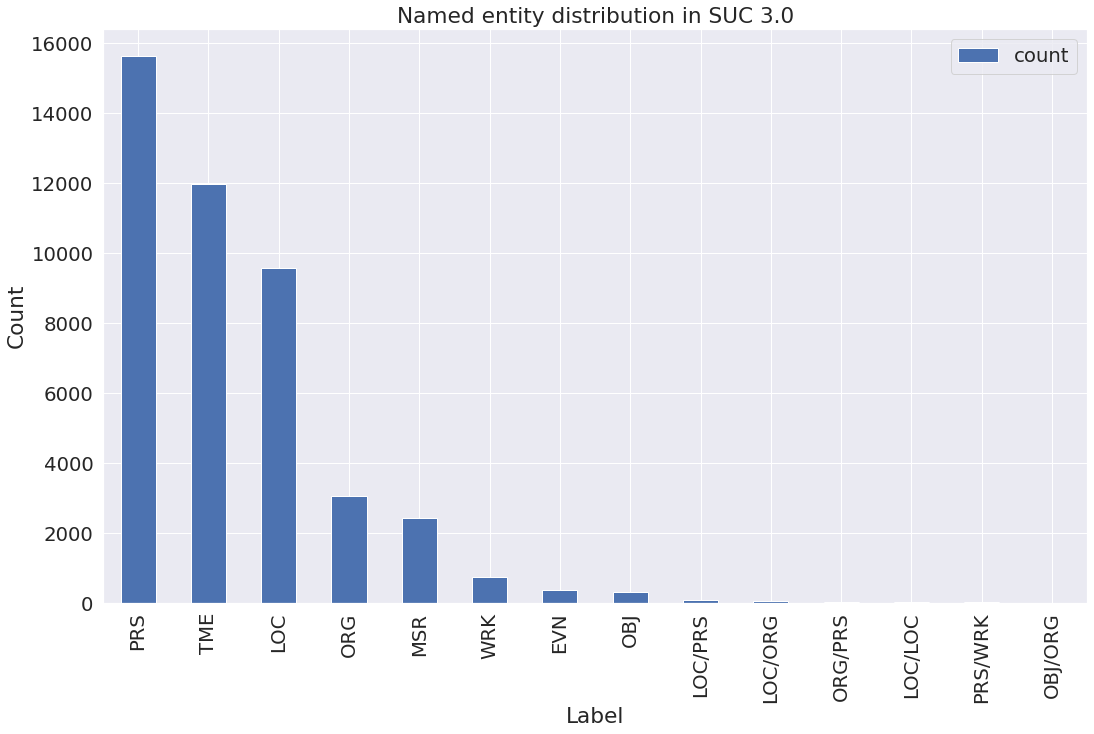

In [38]:
dist_df = dist_df.sort_values(by='count', ascending=False)

fig, ax = plt.subplots(figsize = (15, 10))
dist_df.plot(kind='bar', ax = ax)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title("Named entity distribution in SUC 3.0")
fig.tight_layout(pad=0)
plt.savefig("../data/assets/entity_distribution.png")
plt.show()